## Acoustic Scattering Produced by a Circular Obstacle in an Infinite Domain

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from scat_circ import sound_hard_circle_calc
from scat_circ import mask_displacement
from scat_circ import plot_exact_displacement
from scat_circ import plot_mesh_from_file
from scat_circ import measure_execution_time
from scat_circ import extract_fem_displacements
from scat_circ import plot_fem_displacements
from scat_circ import plot_pinns_displacements
from scat_circ import calculate_relative_errors
from pinns_scat_circ import generate_points
from pinns_scat_circ import plot_points
from pinns_scat_circ import initialize_and_load_model
from pinns_scat_circ import predict_displacement_pinns 
from pinns_scat_circ import process_displacement_pinns
from pinns_scat_circ import measure_model_time_pinns

#### Parameters of the model

In [3]:
r_i = np.pi/4 # Inner radius
l_se = np.pi # Outer semi-length
k = 3.0  # Wave number
n_grid = 401 # Number of grid points in x and y 

# Create a grid of points in the domain
Y, X = np.mgrid[-l_se:l_se:n_grid*1j, -l_se:l_se:n_grid*1j]

### Analytical Solution

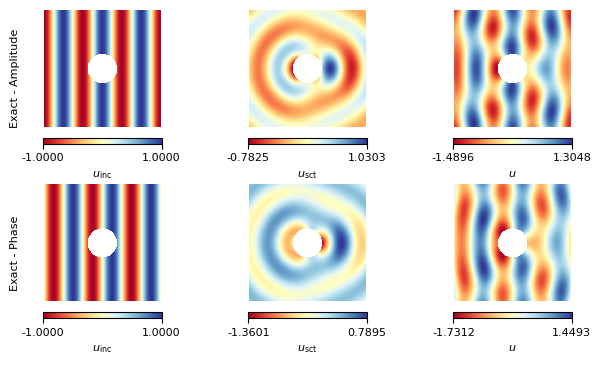

In [28]:
import matplotlib.pyplot as plt

# Calculate the radial distance from the origin for each point in the grid
R_exact = np.sqrt(X**2 + Y**2)

# Calculate the displacement for a sound-hard circular obstacle
# n_terms: number of terms in the series expansion
u_inc_exact, u_scn_exact, u_exact = sound_hard_circle_calc(k, r_i, X, Y, n_terms=None)

# Mask the displacement
u_inc_exact = mask_displacement(R_exact, r_i, l_se, u_inc_exact)
u_scn_exact = mask_displacement(R_exact, r_i, l_se, u_scn_exact)
u_exact = mask_displacement(R_exact, r_i, l_se, u_exact)

# Plot the displacement amplitude
plot_exact_displacement(X, Y, np.real(u_inc_exact), np.real(u_scn_exact), np.real(u_exact), np.imag(u_inc_exact), np.imag(u_scn_exact), np.imag(u_exact))

In [ ]:
# Plot the displacement amplitude
plot_exact_displacement(X, Y, np.real(u_inc_exact), np.real(u_scn_exact), np.real(u_exact), np.imag(u_inc_exact), np.imag(u_scn_exact), np.imag(u_exact))

### Finite Element Method (FEM)

#### Mesh

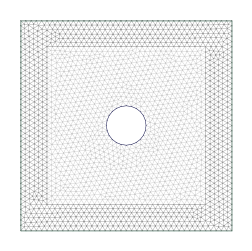

In [32]:
# plot the mesh from the file for illustration with reduced number of points
file_path_msh = "AcousticScattering/scattering_ilustrative.msh"
plot_mesh_from_file(file_path_msh)

#### FEM solution

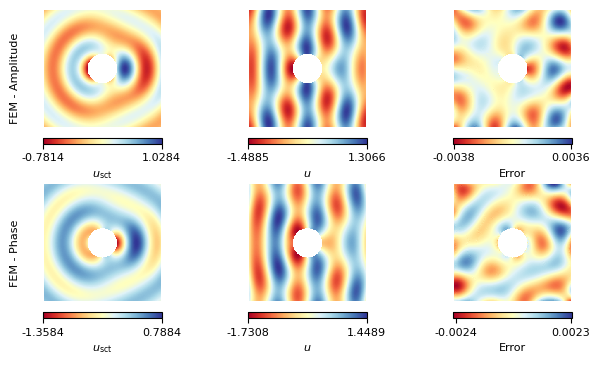

In [27]:
# data u_scn
file_path_u_scn = "AcousticScattering/u.pos"
uscn_amp_interp_fem, uscn_phase_interp_fem, u_amp_fem, u_phase_fem, \
diff_uscn_amp_fem, diff_u_amp_fem, diff_u_scn_phase_fem, diff_u_phase_fem = \
extract_fem_displacements(file_path_u_scn, r_i, l_se, k, n_grid, u_scn_exact, u_exact)
plot_fem_displacements(X, Y, uscn_amp_interp_fem, u_amp_fem, diff_u_amp_fem, uscn_phase_interp_fem, u_phase_fem, diff_u_scn_phase_fem)

#### Accuracy

In [36]:
# Calculate and print the relative errors
rel_error_uscn_amp_fem, rel_error_uscn_phase_fem, max_diff_uscn_amp_fem, min_diff_uscn_amp_fem, max_diff_u_phase_fem, min_diff_u_phase_fem = calculate_relative_errors(u_scn_exact, u_exact, diff_uscn_amp_fem, diff_u_scn_phase_fem, R_exact, r_i)
print(f"Relative error in the scattered field (u_scn) amplitude: {rel_error_uscn_amp_fem:.2e}")
print(f"Relative error in the he scattered field (u_scn) phase: {rel_error_uscn_phase_fem:.2e}")
print(f"Max diff in the scattered field (u_scn) amplitude: {max_diff_uscn_amp_fem:.2e}")
print(f"Min diff in the scattered field (u_scn) amplitude: {min_diff_uscn_amp_fem:.2e}")
print(f"Max diff in the scattered field (u_scn) phase: {max_diff_u_phase_fem:.2e}")
print(f"Min diff in the scattered field (u_scn) phase: {min_diff_u_phase_fem:.2e}")

Relative error in the scattered field (u_scn) amplitude: 1.09e-02
Relative error in the he scattered field (u_scn) phase: 1.95e-02
Max diff in the scattered field (u_scn) amplitude: 3.68e-03
Min diff in the scattered field (u_scn) amplitude: -3.84e-03
Max diff in the scattered field (u_scn) phase: 2.35e-03
Min diff in the scattered field (u_scn) phase: -2.49e-03


#### Computation time

In [38]:
# Define the path to the getdp executable (this can be changed per machine)
getdp_path = "/home/orincon/onelab-Linux64/getdp"

# Define the rest of the command arguments to solve the model using getdp
command_args = "AcousticScattering/scattering.pro -solve Scattering -pos Wave -v2"

# Number of runs to measure statistically
num_runs = 1  # You can change this based on how many runs you want

# Example usage
average_time_fem, std_dev_time_fem, min_time_fem, max_time_fem = measure_execution_time(getdp_path, command_args, num_runs)
print(f"Statistical Measurement of Execution Time (over {num_runs} runs):")
print(f"Average Time: {average_time_fem} seconds")
print(f"Standard Deviation: {std_dev_time_fem} seconds")
print(f"Minimum Time: {min_time_fem} seconds")
print(f"Maximum Time: {max_time_fem} seconds")

Statistical Measurement of Execution Time (over 1 runs):
Average Time: 2.763 seconds
Standard Deviation: 0.0 seconds
Minimum Time: 2.763 seconds
Maximum Time: 2.763 seconds


### Physics informed neural networks (PINNs)

#### Collocation points

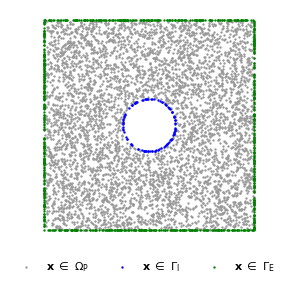

In [31]:
# Parameters
n_Omega_P = 5_000        # Number of points inside the annular region
n_Gamma_I = 100          # Number of points on the inner boundary (r = r_i)
n_Gamma_E = 200          # Number of points on the outer boundary (r = r_e)
r_i = np.pi / 4          # Inner radius
l_se = np.pi              # Length of the semi-edge of the square
k = 3.0                  # Wave number
iter = 0                 # Iteration counter
side_length = 2 * l_se    # Side length of the square

# Generate points
x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top = generate_points(n_Omega_P, side_length, r_i, n_Gamma_I, n_Gamma_E)
plot_points(x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top)

#### Physics informed neural networks (PINNs) solution

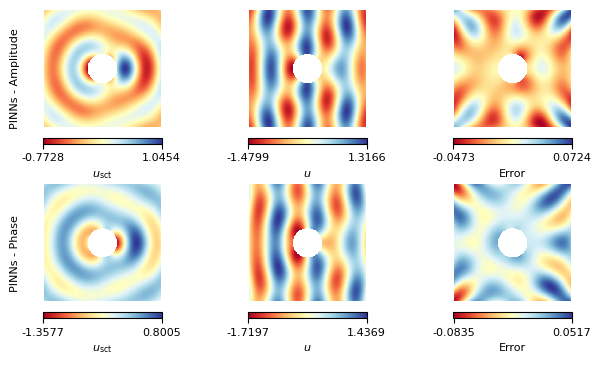

In [24]:
# Initialize and load the model
model_path = 'Scattering.pt'
model = initialize_and_load_model(model_path)

# Predict the displacement
u_sc_amp_pinns, u_sc_phase_pinns, u_amp_pinns, u_phase_pinns = predict_displacement_pinns(model, l_se, r_i, k, n_grid)

# Example usage
u_sc_amp_pinns,u_sc_phase_pinns,u_amp_pinns, u_phase_pinns, diff_uscn_amp_pinns, diff_u_scn_phase_pinns = process_displacement_pinns(
    model, l_se, r_i, k, n_grid, X, Y, R_exact, u_scn_exact
)

plot_pinns_displacements(X, Y, u_sc_amp_pinns, u_amp_pinns, diff_uscn_amp_pinns, u_sc_phase_pinns, u_phase_pinns, diff_u_scn_phase_pinns)

#### Accuracy

In [35]:
# Calculate and print the relative errors
rel_error_uscn_amp_pinns, rel_error_uscn_phase_pinns, max_diff_uscn_amp_pinns, min_diff_uscn_amp_pinns, max_diff_u_phase_pinns, min_diff_u_phase_pinns = calculate_relative_errors(u_scn_exact, u_exact, diff_uscn_amp_pinns, diff_u_scn_phase_pinns, R_exact, r_i)
print(f"Relative error in the scattered field (u_scn): {rel_error_uscn_amp_pinns:.2e}")
print(f"Relative error in the total field (u): {rel_error_uscn_phase_pinns:.2e}")
print(f"Max diff in the scattered field (u_scn): {max_diff_uscn_amp_pinns:.2e}")
print(f"Min diff in the scattered field (u_scn): {min_diff_uscn_amp_pinns:.2e}")
print(f"Max diff in the total field (u): {max_diff_u_phase_pinns:.2e}")
print(f"Min diff in the total field (u): {min_diff_u_phase_pinns:.2e}")


Relative error in the scattered field (u_scn): 7.47e-02
Relative error in the total field (u): 7.45e-02
Max diff in the scattered field (u_scn): 7.25e-02
Min diff in the scattered field (u_scn): -4.73e-02
Max diff in the total field (u): 5.17e-02
Min diff in the total field (u): -8.36e-02


#### Computation time

In [71]:
num_runs = 100
average_time_pinns, std_dev_time_pinns, min_time_pinns, max_time_pinns = measure_model_time_pinns(model, l_se, r_i, k, n_grid, num_runs)
print(f"Statistical Measurement of Execution Time (over {num_runs} runs):")
print(f"Average Time: {average_time_pinns:.3f} seconds")
print(f"Standard Deviation: {std_dev_time_pinns:.3f} seconds")
print(f"Minimum Time: {min_time_pinns:.3f} seconds")
print(f"Maximum Time: {max_time_pinns:.3f} seconds")

Statistical Measurement of Execution Time (over 100 runs):
Average Time: 0.059 seconds
Standard Deviation: 0.023 seconds
Minimum Time: 0.041 seconds
Maximum Time: 0.282 seconds


Statistical Measurement of Execution Time (over 100 runs):
Average Time: 0.059 seconds
Standard Deviation: 0.023 seconds
Minimum Time: 0.041 seconds
Maximum Time: 0.282 seconds

### Comparative

In [ ]:
# Crear un diccionario con los resultados
resultados = {
    'Método': ['FEM', 'PINNs'],
    'Tiempo Promedio (s)': [average_time_fem, average_time_fem],
    'Desviación Estándar (s)': [std_dev_time_fem, average_time_fem],
    'Tiempo Mínimo (s)': [min_time_fem, average_time_fem],
    'Tiempo Máximo (s)': [max_time_fem, average_time_fem]
}

# Crear un DataFrame de pandas
df_resultados = pd.DataFrame(resultados)

# Guardar el DataFrame en un archivo CSV
df_resultados.to_csv('tiempos.csv', index=False)


# Crear un diccionario con los resultados de errores relativos
resultados_errores = {
    'Método': ['FEM', 'PINNs'],
    'Error Relativo u_scn (Amp)': [rel_error_uscn_amp_fem, rel_error_uscn_amp_pinns],
    'Error Relativo u (Phase)': [rel_error_uscn_phase_fem, rel_error_uscn_phase_pinns],
    'Max Diff u_scn (Amp)': [max_diff_uscn_amp_fem, max_diff_uscn_amp_pinns],
    'Min Diff u_scn (Amp)': [min_diff_uscn_amp_fem, min_diff_uscn_amp_pinns],
    'Max Diff u (Phase)': [max_diff_u_phase_fem, max_diff_u_phase_pinns],
    'Min Diff u (Phase)': [min_diff_u_phase_fem, min_diff_u_phase_pinns]
}

# Crear un DataFrame de pandas
df_errores = pd.DataFrame(resultados_errores)

# Guardar el DataFrame en un archivo CSV con notación científica
df_errores.to_csv('datos/errores.csv', index=False, float_format='%.2e')
